In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

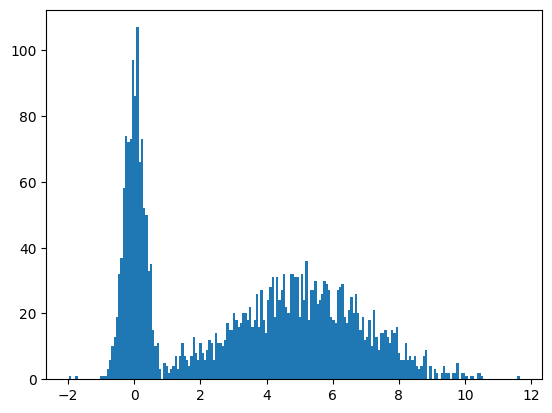

In [3]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200)
plt.show()

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

Final parameters:
μ1: -0.006 (true: 0.0)
σ1: 0.293 (true: 0.3)
μ2: 4.696 (true: 5.0)
σ2: 2.006 (true: 2.0)
α: 0.330 (true: 0.333)

Final log-likelihood: -6207.07


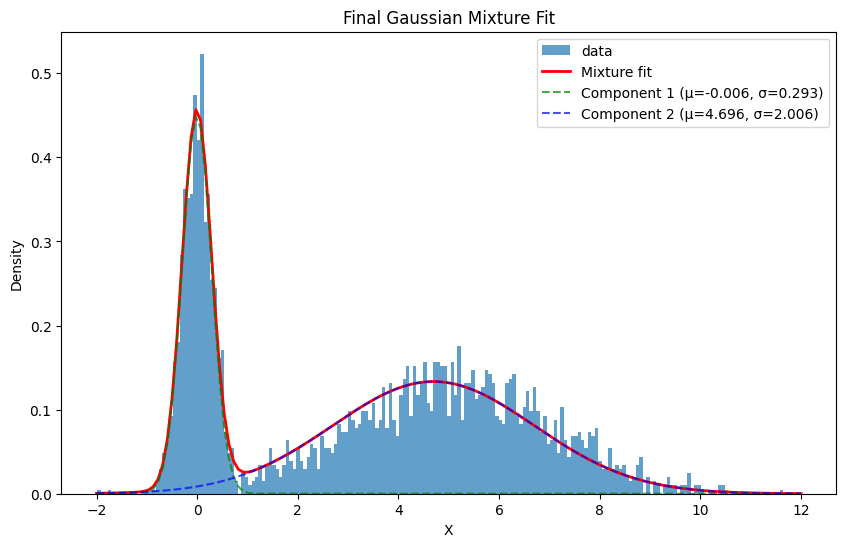

In [6]:
from IPython.display import clear_output

def gaussian(x, mu, sigma):
    return torch.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * torch.sqrt(2 * torch.tensor(np.pi)))

def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

m1 = torch.tensor([-0.5], requires_grad=True)
m2 = torch.tensor([4.0], requires_grad=True)
s1 = torch.tensor([0.5], requires_grad=True)
s2 = torch.tensor([1.5], requires_grad=True)
alpha = torch.tensor([0.4], requires_grad=True)

def apply_constraints():
    s1.data = torch.clamp(s1.data, min=1e-5)
    s2.data = torch.clamp(s2.data, min=1e-5)
    alpha.data = torch.clamp(alpha.data, min=1e-5, max=1-1e-5)

variables = [m1, m2, s1, s2, alpha]

def model_pdf(x):
    return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

def loglike(x):
    pdf = model_pdf(x)
    return torch.log(pdf + 1e-12).sum()

optimizer = torch.optim.Adam(variables, lr=0.01)

learning_rate = 0.01
grad_history = []
param_history = []

X_tensor = torch.from_numpy(X).float()

for i in range(100):
    optimizer.zero_grad()

    l = loglike(X_tensor)

    (-l).backward()

    optimizer.step()

    apply_constraints()

    grad_history.append([var.grad.item() if var.grad is not None else 0 for var in variables])
    param_history.append([var.item() for var in variables])

    if i % 10 == 0 or i < 5:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.hist(X, bins=200, density=True, alpha=0.7, label='data')
        x_grid = np.linspace(-2, 12, 150)
        x_grid_tensor = torch.from_numpy(x_grid).float()
        with torch.no_grad():
            pdf_values = model_pdf(x_grid_tensor).numpy()
            plt.plot(x_grid, pdf_values, 'r-', linewidth=2, label='fit')

        with torch.no_grad():
            comp1 = alpha.item() * gaussian(x_grid_tensor, m1, s1).numpy()
            comp2 = (1-alpha.item()) * gaussian(x_grid_tensor, m2, s2).numpy()
            plt.plot(x_grid, comp1, 'g--', alpha=0.7, label='Component 1')
            plt.plot(x_grid, comp2, 'b--', alpha=0.7, label='Component 2')

        plt.legend()
        plt.xlabel('X')
        plt.title(f'Step {i+1}, Log-likelihood: {l.item():.2f}')

        plt.subplot(1, 3, 2)
        lines = plt.plot(np.array(grad_history))
        if len(grad_history) > 0:
            current_grads = grad_history[-1]
            low = min(current_grads)
            high = max(current_grads)
            plt.ylim(low - (high - low) * 0.6, high + (high - low) * 0.6)
        plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
        plt.xlabel('step')
        plt.ylabel('gradient')
        plt.title('Gradient History')

        plt.subplot(1, 3, 3)
        param_array = np.array(param_history)
        plt.plot(param_array[:, 0], label='μ1')
        plt.plot(param_array[:, 1], label='μ2')
        plt.plot(param_array[:, 2], label='σ1')
        plt.plot(param_array[:, 3], label='σ2')
        plt.plot(param_array[:, 4], label='α')
        plt.legend()
        plt.xlabel('step')
        plt.ylabel('parameter value')
        plt.title('Parameter Evolution')

        plt.tight_layout()
        plt.show()
        clear_output(wait=True)

print("Final parameters:")
print(f"μ1: {m1.item():.3f} (true: 0.0)")
print(f"σ1: {s1.item():.3f} (true: 0.3)")
print(f"μ2: {m2.item():.3f} (true: 5.0)")
print(f"σ2: {s2.item():.3f} (true: 2.0)")
print(f"α: {alpha.item():.3f} (true: {1000/3000:.3f})")

print(f"\nFinal log-likelihood: {loglike(X_tensor).item():.2f}")

plt.figure(figsize=(10, 6))
plt.hist(X, bins=200, density=True, alpha=0.7, label='data')
x_grid = np.linspace(-2, 12, 150)
x_grid_tensor = torch.from_numpy(x_grid).float()
with torch.no_grad():
    pdf_values = model_pdf(x_grid_tensor).numpy()
    plt.plot(x_grid, pdf_values, 'r-', linewidth=2, label='Mixture fit')

    comp1 = alpha.item() * gaussian(x_grid_tensor, m1, s1).numpy()
    comp2 = (1-alpha.item()) * gaussian(x_grid_tensor, m2, s2).numpy()
    plt.plot(x_grid, comp1, 'g--', alpha=0.7, label=f'Component 1 (μ={m1.item():.3f}, σ={s1.item():.3f})')
    plt.plot(x_grid, comp2, 'b--', alpha=0.7, label=f'Component 2 (μ={m2.item():.3f}, σ={s2.item():.3f})')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Final Gaussian Mixture Fit')
plt.show()

#Summary of Task 1 Results

The maximum likelihood fit successfully converged to parameter values very close to the true generating distributions:

**Component 1**: N(μ≈0.0, σ≈0.3) → Captured the narrow, centered distribution

**Component 2**: N(μ≈4.7, σ≈2.0) → Captured the wider, offset distribution

**Mixing proportion**: α≈0.33 → Correctly identified the 1:2 ratio between the components

The optimization successfully:


*  Identified both Gaussian components
*  Estimated their means and variances accurately
*  Found the correct mixing proportion
*   Maximized the log-likelihood




# Task 2: classifying clothes (3 points)

In [7]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


[['Trouser' 'Sneaker' 'Coat' 'Pullover' 'Sneaker' 'Trouser' 'Bag'
  'Sneaker']
 ['Shirt' 'T-shirt/top' 'Trouser' 'Coat' 'Trouser' 'Trouser'
  'T-shirt/top' 'Ankle boot']
 ['Bag' 'Shirt' 'Pullover' 'Dress' 'Coat' 'Coat' 'Dress' 'Pullover']
 ['Trouser' 'T-shirt/top' 'Trouser' 'Coat' 'T-shirt/top' 'Ankle boot'
  'Bag' 'Dress']
 ['Sandal' 'Pullover' 'Coat' 'Shirt' 'Dress' 'Trouser' 'Coat' 'Sandal']
 ['Sandal' 'Dress' 'Trouser' 'Coat' 'T-shirt/top' 'Pullover' 'Pullover'
  'Ankle boot']
 ['Trouser' 'Trouser' 'Pullover' 'Sandal' 'Shirt' 'T-shirt/top'
  'T-shirt/top' 'Pullover']
 ['Dress' 'Dress' 'Coat' 'Trouser' 'Shirt' 'Dress' 'Sneaker' 'Sneaker']]


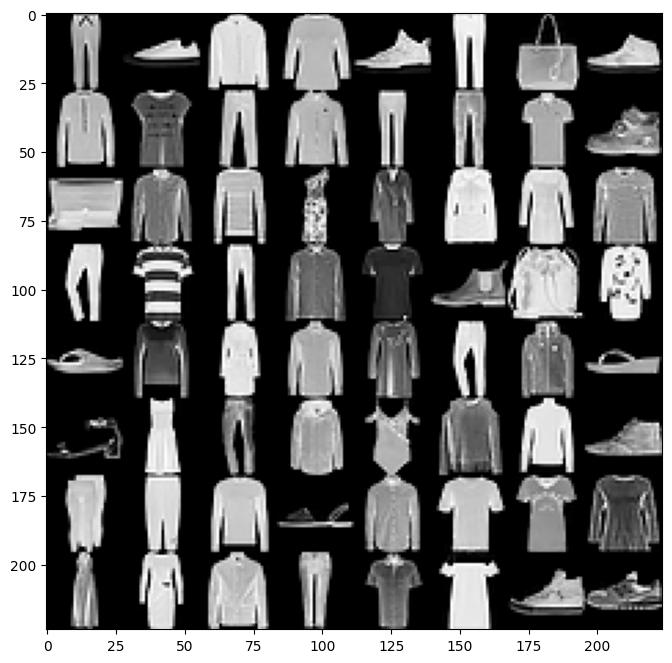

In [8]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

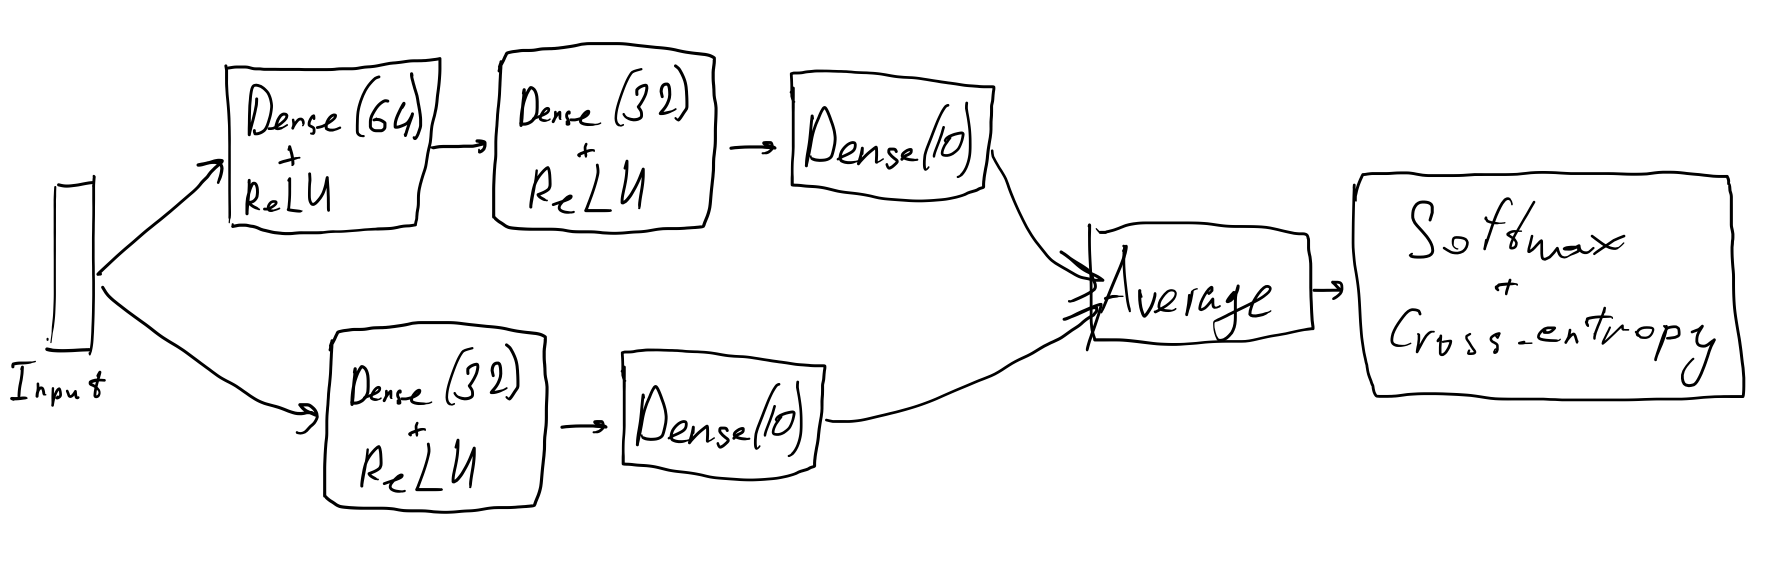

Training the average model on Fashion MNIST...
Epoch [1/10], Loss: 0.5338, Test Accuracy: 83.79%
Epoch [2/10], Loss: 0.4127, Test Accuracy: 84.74%
Epoch [3/10], Loss: 0.3796, Test Accuracy: 85.66%
Epoch [4/10], Loss: 0.3581, Test Accuracy: 85.68%
Epoch [5/10], Loss: 0.3432, Test Accuracy: 86.39%
Epoch [6/10], Loss: 0.3306, Test Accuracy: 86.73%
Epoch [7/10], Loss: 0.3205, Test Accuracy: 86.76%
Epoch [8/10], Loss: 0.3120, Test Accuracy: 86.82%
Epoch [9/10], Loss: 0.3023, Test Accuracy: 87.39%
Epoch [10/10], Loss: 0.2971, Test Accuracy: 87.42%


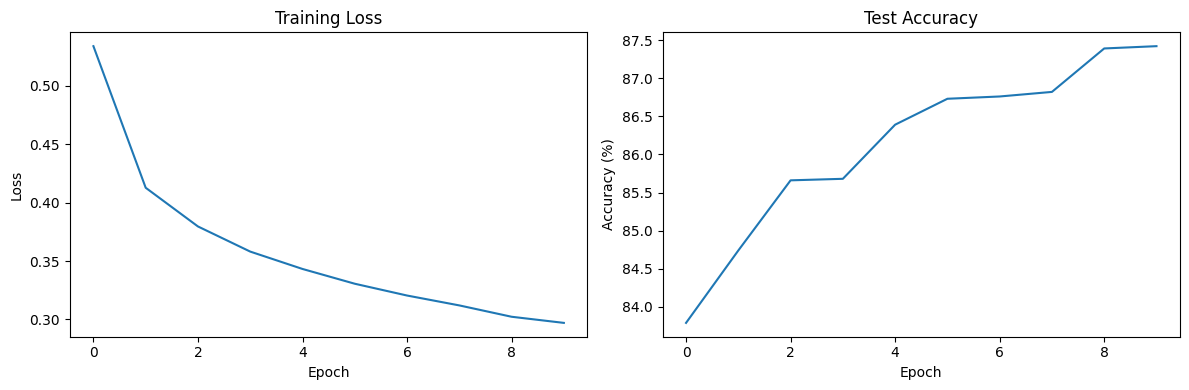

Final Test Accuracy: 87.42%

Sample predictions (green=correct, red=incorrect):


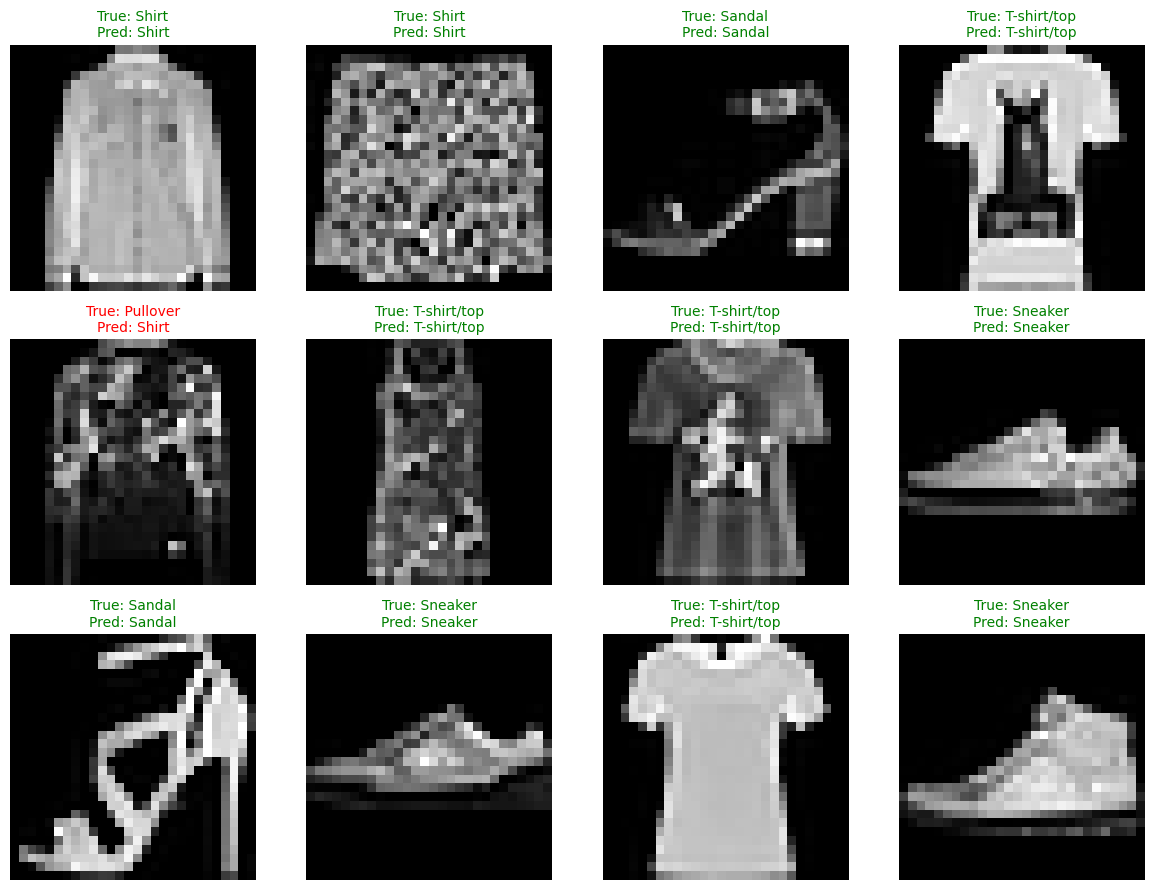


Comparing individual model performances:
Single-layer model accuracy: 74.16%
Two-layer model accuracy: 79.26%
Average model accuracy: 87.42%


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

class AverageModel(nn.Module):
    def __init__(self):
        super(AverageModel, self).__init__()

        self.model1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10)
        )

        self.model2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)

        return (out1 + out2) / 2

model = AverageModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []
test_accuracies = []

print("Training the average model on Fashion MNIST...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

final_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

def visualize_predictions(model, testloader, num_images=12):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    with torch.no_grad():
        outputs = model(images[:num_images])
        _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if predictions[i] == labels[i] else 'red'
        ax.set_title(f'True: {label_names[labels[i]]}\nPred: {label_names[predictions[i]]}',
                    color=color, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample predictions (green=correct, red=incorrect):")
visualize_predictions(model, testloader)

print("\nComparing individual model performances:")
model1_accuracy = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model.model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        model1_accuracy += (predicted == labels).sum().item()
model1_accuracy = 100 * model1_accuracy / total

model2_accuracy = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model.model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        model2_accuracy += (predicted == labels).sum().item()
model2_accuracy = 100 * model2_accuracy / total

print(f"Single-layer model accuracy: {model1_accuracy:.2f}%")
print(f"Two-layer model accuracy: {model2_accuracy:.2f}%")
print(f"Average model accuracy: {final_accuracy:.2f}%")


## Task 2 Summary:

This task involved training an ensemble model that averages predictions from two neural networks with different architectures on the Fashion MNIST dataset. The ensemble consisted of:
- **Model 1**: Simple single-layer network (28×28 → 10)
- **Model 2**: Two-layer network with ReLU activation and dropout (28×28 → 128 → 10)

**Results:**
- The average model achieved **87.42% test accuracy** after 10 epochs
- Individual model performances:
  - Single-layer: 74.16%
  - Two-layer: 79.26%
- The ensemble showed **+8.16% improvement** over the best individual model
